# Preprocessing
- Remove URLs and Mentions
- Separate composite camel case words (e.g. BlackLives --> black lives)
- Remove non-alphanumeric characters
- Replace numbers with the token "_number_"
- Lowercase everything

In [1]:
from src.preprocessing import clean

In [3]:
clean("#BlackLivesMatter https://www.google.com/ @realDonaldTrump")

'black lives matter'

# Encoding
## Universal Sentence Encoder

In [1]:
from src.encoder import Encoder

In [2]:
# default encoder is USE for English only.
# But you can use multilingual as well, like ...
encoder = Encoder(model_url="https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [5]:
encoder.encode("hello world")

array([[ 9.02929604e-02,  2.53139641e-02, -8.63993599e-04,
         3.37017924e-02, -6.26476333e-02, -4.42366041e-02,
         2.18325537e-02,  5.37963435e-02, -8.38939548e-02,
        -9.51755140e-03, -3.12121455e-02, -5.35302460e-02,
        -4.03429270e-02, -6.45988435e-02, -4.22783829e-02,
         6.87545631e-03,  2.68412735e-02,  1.69232395e-02,
         4.52055521e-02, -7.21441209e-02,  7.80028552e-02,
         7.60580525e-02, -4.91863601e-02, -3.33283916e-02,
        -6.48475764e-03,  5.31073436e-02,  5.94470128e-02,
         4.97598015e-02, -5.83836809e-02,  4.62118129e-04,
        -2.54417248e-02, -4.07968946e-02,  2.24085082e-03,
        -5.71764819e-02,  3.96157652e-02, -5.56416325e-02,
         1.06351763e-01, -2.11038422e-02, -4.97004427e-02,
         1.37671484e-02,  2.52124630e-02,  6.93862326e-03,
        -8.78239796e-03, -4.25839275e-02, -7.41932988e-02,
         3.93395983e-02, -5.14756478e-02, -4.80900072e-02,
         2.03796737e-02,  4.60575111e-02, -5.39578963e-0

In [10]:
import pandas as pd

df = pd.DataFrame({
    "username":["user1", "user1", "user2", "user2"],
    "text": ["hello world", "merhaba dunya", "Bonjour le monde", "مرحبا بالعالم"]
})
df

,username,text
0,user1,hello world
1,user1,merhaba dunya
2,user2,Bonjour le monde
3,user2,مرحبا بالعالم


In [11]:
encoder.encode_df(df, user_col="username", text_col="text", out_path="demo.npz")

100%|██████████| 2/2 [00:00<00:00, 95.93it/s]


In [12]:
f = np.load("demo.npz")
f["users"]

array(['user1', 'user2'], dtype='<U5')

In [13]:
f["vectors"]

array([[ 0.1271717 ,  0.00337878, -0.00207015, ..., -0.03947673,
         0.02093398, -0.00205181],
       [ 0.07556362, -0.00347732, -0.01797179, ..., -0.0588544 ,
         0.02632636, -0.00710142]], dtype=float32)

In [14]:
f["vectors"].shape

(2, 512)

## BERT

In [15]:
from src.encoder import EncoderBERT

encoder = EncoderBERT("roberta-base-nli-stsb-mean-tokens")

# same API

# Projection

In [17]:
from src.projection import Projector, os

In [18]:
projector = Projector("election_vectors.npz")

In [20]:
projector.project("projections.npz", min_counts=3, min_dist=0.0, n_neighbors=30)

In [21]:
os.makedirs("trials")

projector.grid_search(
    trials_dir="trials",
    min_counts=3, # minimum 3 tweets per user
    min_dists_range = [0.0, 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.99],
    n_neighbors_range=[20, 30, 40, 50, 60, 70, 80, 90, 100]
)

# Clustering

In [25]:
from src.clustering import Clusterer, pickle

In [22]:
clusterer = Clusterer("projections.npz")

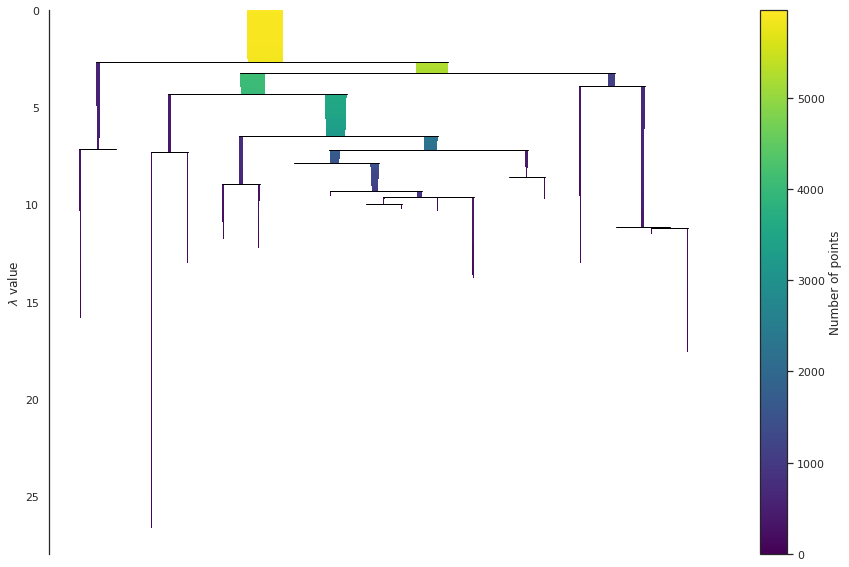

In [34]:
clusterer.cluster(tree_path="tree.pkl")

clusterer.plot_tree(path="tree.pkl")

## Injecting labels

In [36]:
# this is just an example. We are hiding the actual labels of real users here
labels = pd.DataFrame({"username":["user1", "user2"], "label":["pro", "anti"]})
labels

,username,label
0,user1,pro
1,user2,anti


In [38]:
clusterer.inject_labels(users=labels.username, labels=labels.label)

clusterer.align_clusters_with_labels(
    # this means multiple clusters can be assigned the same label
    allow_multiple_clusters=True
)

## Example on Turkish Election dataset

In [39]:
clusterer.plot()

<img src="ed.png">

## Example on Trump dataset

In [37]:
# this calculates the micro f1 score for all umap configurations in the grid search
# and plots the result of each configuration
# then returns the results matrix and a heatmap plot of it
results, hm = cluster_projection_grid_search(
    "trials", users=labels.username, labels=labels.label,
    # this means multiple clusters can be assigned the same label
    allow_multiple_clusters=True
)

Example of plotted projections and grid search heatmap
<img src="trials/hm.png?">
<img src="trials/0.0_30.png?">
<img src="trials/0.1_60.png?">